## Library

In [31]:
import numpy as np
import pandas as pd
import random
from PIL import Image

In [32]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize

In [33]:
import warnings
warnings.filterwarnings("ignore")

In [34]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [35]:
print ("PyTorch version:[%s]."%(torch.__version__))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #'cuda:0'
print ("device:[%s]."%(device))

PyTorch version:[1.7.1].
device:[cuda].


In [36]:
# seed 고정
def set_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)
    
set_seed(42)

## Dataset

In [37]:
TRAIN_PATH = '/opt/ml/input/data/train/data.csv'

In [38]:
class Custom_Dataset(Dataset):
    def __init__(self, path, target, transforms, train=True):
        self.train = train
        self.path = path
        self.transform = transforms
        
        self.data = pd.read_csv(path, index_col=0)
        self.data = self.data.sample(frac=1).reset_index(drop=True)

        if self.train:
            self.data = self.data[:int(len(self.data) * 0.8)]
        else:
            self.data = self.data[int(len(self.data) * 0.8 + 1):]
        
        self.classes = np.sort(self.data[target].unique())
        self.y = self.data[target]
        self.X = []
        
        for path in self.data['path']:
            im = Image.open(path)
            self.X.append(im)
        

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        X, y = self.X[idx], self.y[idx]
        if self.transform:
          X = self.transform(X)
        return X, torch.tensor(y, dtype=torch.long)

In [39]:
# dataset = Custom_Dataset(path=TRAIN_PATH, target='class', transforms=transforms.Compose([transforms.ToTensor()]), train=True)

# mean_rgb = [np.mean(x.numpy(), axis=(1,2)) for x, _ in dataset]
# std_rgb = [np.std(x.numpy(), axis=(1,2)) for x, _ in dataset]

In [40]:
# mean_r = np.mean([m[0] for m in mean_rgb])
# mean_g = np.mean([m[1] for m in mean_rgb])
# mean_b = np.mean([m[2] for m in mean_rgb])

# std_r = np.mean([s[0] for s in std_rgb])
# std_g = np.mean([s[1] for s in std_rgb])
# std_b = np.mean([s[2] for s in std_rgb])

In [41]:
# print(mean_r, mean_g, mean_b)
# print(std_r, std_g, std_b)

In [42]:
mean_r, mean_g, mean_b = 0.5601936, 0.52410126, 0.501457
std_r, std_g, std_b = 0.23318605, 0.24300034, 0.24567522

In [43]:
transform = transforms.Compose([
    transforms.CenterCrop(244),
    transforms.ToTensor(),
    transforms.Normalize((mean_r, mean_g, mean_b),(std_r, std_g, std_b))
])

In [44]:
train_dataset = Custom_Dataset(path=TRAIN_PATH, target='class', transforms=transform, train=True)
test_dataset = Custom_Dataset(path=TRAIN_PATH, target='class', transforms=transform, train=False)

In [45]:
train_dataloader = DataLoader(train_dataset, batch_size=18, shuffle=True, num_workers=1)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([244, 244, 3])


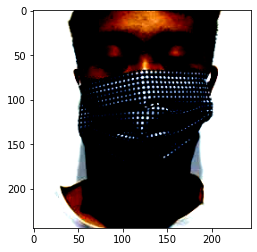

In [46]:
# Sample Image
import matplotlib.pyplot as plt
image, label = next(iter(train_dataset))

image = image.permute(1,2,0)
plt.imshow(image)

print(image.shape)

## Model

In [47]:
from torchvision import models

In [48]:
resnet = models.resnet18(pretrained=True)

In [49]:
CLASS_NUM = 18

In [50]:
in_ftr = resnet.fc.in_features
resnet.fc = torch.nn.Linear(in_features=in_ftr, out_features=CLASS_NUM, bias=True)
resnet.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Mask

In [51]:
from torchsummary import summary
summary(resnet, input_size=(3, 244, 244), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 122, 122]           9,408
       BatchNorm2d-2         [-1, 64, 122, 122]             128
              ReLU-3         [-1, 64, 122, 122]               0
         MaxPool2d-4           [-1, 64, 61, 61]               0
            Conv2d-5           [-1, 64, 61, 61]          36,864
       BatchNorm2d-6           [-1, 64, 61, 61]             128
              ReLU-7           [-1, 64, 61, 61]               0
            Conv2d-8           [-1, 64, 61, 61]          36,864
       BatchNorm2d-9           [-1, 64, 61, 61]             128
             ReLU-10           [-1, 64, 61, 61]               0
       BasicBlock-11           [-1, 64, 61, 61]               0
           Conv2d-12           [-1, 64, 61, 61]          36,864
      BatchNorm2d-13           [-1, 64, 61, 61]             128
             ReLU-14           [-1, 64,

In [76]:
class F1_Loss(nn.Module):
    def __init__(self, classes=18, epsilon=1e-7):
        super().__init__()
        self.classes = classes
        self.epsilon = epsilon

    def forward(self, y_pred, y_true):
        assert y_pred.ndim == 2
        assert y_true.ndim == 1

        # ce = nn.functional.cross_entropy(y_pred, y_true)

        y_true = F.one_hot(y_true, self.classes).to(torch.float32)
        y_pred = F.softmax(y_pred, dim=1)

        tp = (y_true * y_pred).sum(dim=0).to(torch.float32)
        tn = ((1 - y_true) * (1 - y_pred)).sum(dim=0).to(torch.float32)
        fp = ((1 - y_true) * y_pred).sum(dim=0).to(torch.float32)
        fn = (y_true * (1 - y_pred)).sum(dim=0).to(torch.float32)

        precision = tp / (tp + fp + self.epsilon)
        recall = tp / (tp + fn + self.epsilon)

        f1 = 2 * (precision * recall) / (precision + recall + self.epsilon)
        f1 = f1.clamp(min=self.epsilon, max=1 - self.epsilon)
        return (1 - f1.mean())

In [72]:
lr_rate = 1e-3
epochs = 10

loss_fn = F1_Loss().to(device)
optimizer = torch.optim.Adam(resnet.parameters(), lr=lr_rate)

In [ ]:
torch.cuda.empty_cache()

for epoch in range(epochs):
    running_loss = 0
    for index, (images, labels) in enumerate(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        logits = resnet(images)
        _, preds = torch.max(logits, 1)
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(train_dataloader.dataset)
    print(f'epoch : {epoch}, loss : {epoch_loss:.3f}')


## eval

In [69]:
len(test_dataloader.dataset), len(train_dataloader.dataset)

(3779, 15120)

In [ ]:
correct = 0
resnet.eval()

with torch.no_grad():
	for index, (image, label) in enumerate(train_dataloader):
		image = image.to(device)
		label = label.to(device)
		output = resnet(image)
		_, pred = torch.max(output, 1)
		correct += (pred == label).sum().item()
		print(index, (pred == label))

In [64]:
print('accuracy %f'%(correct.sum() / len(test_dataloader.dataset)))

accuracy 1.116962


tensor(4221, device='cuda:0')

f1_loss -> 8%

cross entropy -> ???